In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets.fashion_mnist as ds



In [0]:
(train_images, train_labels),(test_images, test_labels) = ds.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
print(train_images.shape)

(60000, 28, 28, 1)


In [0]:
img_index = 3                                                    

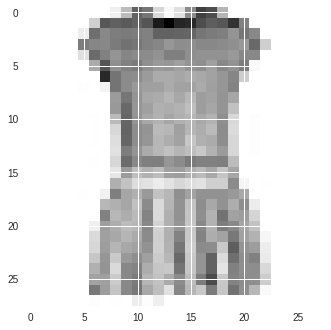

In [0]:
plt.imshow(train_images[img_index].reshape(28,28))

In [0]:

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [0]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.ERROR)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

In [0]:
history = tpu_model.fit(train_images, train_labels,
                        epochs=20,
                        batch_size=128 * 8)


Epoch 1/20
60000/60000 [==============================] - 11s 186us/step - loss: 1.1575 - acc: 0.5836
Epoch 2/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.7061 - acc: 0.7379
Epoch 3/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.5649 - acc: 0.7875
Epoch 4/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.4991 - acc: 0.8145
Epoch 5/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.4503 - acc: 0.8355
Epoch 6/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.4161 - acc: 0.8472
Epoch 7/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.3867 - acc: 0.8586
Epoch 8/20
60000/60000 [==============================] - 2s 26us/step - loss: 0.3648 - acc: 0.8672
Epoch 9/20
60000/60000 [==============================] - 1s 25us/step - loss: 0.3455 - acc: 0.8730
Epoch 10/20
60000/60000 [==============================] - 2s 25us/step - loss: 0.3276 - acc: 0.87

In [0]:
tpu_model.evaluate(test_images, test_labels, batch_size=128 * 8)

10000/10000 [==============================] - 4s 389us/step


[0.28891048345565795, 0.8972999990463257]

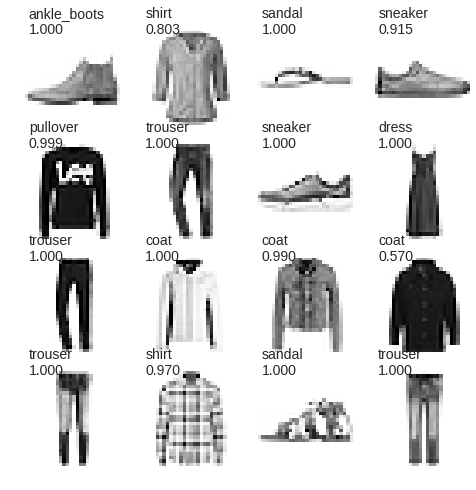

In [0]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']


cpu_model = tpu_model.sync_to_cpu()

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    
    label = LABEL_NAMES[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, label + '\n%.3f' % confidence, fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

plot_predictions(np.squeeze(test_images[:16]), 
                 cpu_model.predict(test_images[:16]))